# Расчет общих микросостояний на основе всех имеющихся

In [1]:
import pandas as pd

from helper import *
from neurokit2.stats.cluster import cluster
import scipy
import numpy as np
import sklearn


In [2]:
def _microstates_segment_runsegmentation(data, microstates, gfp, n_microstates):
    # Find microstate corresponding to each datapoint
    activation = microstates.dot(data)
    segmentation = np.argmax(np.abs(activation), axis=0)
    polarity = np.sign(np.choose(segmentation, activation))

    # Get Global Explained Variance (GEV)
    gev, gev_all = _cluster_quality_gev(
        data.T, microstates, segmentation, sd=gfp, n_clusters=n_microstates
    )
    return segmentation, polarity, gev, gev_all

def _cluster_quality_gev(data, clusters, clustering, sd=None, n_clusters=4):
    """Global Variance Explained (GEV)"""
    if sd is None:
        sd = np.nanstd(data, axis=1)
    map_corr = _correlate_vectors(data.T, clusters[clustering].T)

    gev_all = np.zeros(n_clusters)
    for state in range(n_clusters):
        idx = clustering == state
        gev_all[state] = np.nansum((sd[idx] * map_corr[idx]) ** 2) / np.nansum(sd**2)

    gev = np.nansum(gev_all)
    #    gev = np.sum((sd * map_corr) ** 2) / np.sum(sd**2)
    return gev, gev_all


def _correlate_vectors(A, B, axis=0):
    """Compute pairwise correlation of multiple pairs of vectors.
    Fast way to compute correlation of multiple pairs of vectors without
    computing all pairs as would with corr(A,B). Borrowed from Oli at Stack
    overflow.

    Note the resulting coefficients vary slightly from the ones
    obtained from corr due differences in the order of the calculations.
    (Differences are of a magnitude of 1e-9 to 1e-17 depending of the tested
    data).

    Parameters
    ----------
    A : array
        The first collection of vectors of shape (n, m)
    B : array
        The second collection of vectors of shape (n, m)
    axis : int
        The axis that contains the elements of each vector. Defaults to 0.

    Returns
    -------
    corr : array
        For each pair of vectors, the correlation between them with shape (m, )

    """
    An = A - np.nanmean(A, axis=axis)
    Bn = B - np.nanmean(B, axis=axis)
    An /= np.linalg.norm(An, axis=axis)
    Bn /= np.linalg.norm(Bn, axis=axis)
    return np.nansum(An * Bn, axis=axis)

In [3]:
raw_data_folder_path = "./raw_data/"
preprocessed_data_folder_path = "./preprocessed_data/"
save_data_folder_path = "./save_data/"
images_folder_path = "./images/"
statistics_folder_path = "statistics/"
mhw_objects_folder_path = "mhw_objects/"

folders = Folders(
    end_folder = "",
    raw_data = raw_data_folder_path,
    preprocessed_data = preprocessed_data_folder_path,
    save_data = save_data_folder_path,
    images = images_folder_path,
    statistics=statistics_folder_path,
    mhw_objects=mhw_objects_folder_path
)


filenames014 = [
    "ACP_INP0014_REST1_1pnt_1vis",
    "ACP_INP0014_REST2_1pnt_1vis",
    "ACP_INP0014_REST3_1pnt_1vis",
    "ACP_INP0014_REST1_1pnt_2vis",
    "ACP_INP0014_REST2_1pnt_2vis",
    "ACP_INP0014_REST3_1pnt_2vis"
]
path014 = "rest_14/"

filenames019 = [
    "INP0019_v1.4_REST1_R003_R003_08.11.23",
    "INP0019_v1.4_REST2_R003_R003_08.11.23",
    "INP0019_v1.4_REST3_R003_R003_08.11.23",
    "INP0019_v1.5_REST2_Op005_Op007_08.12.23",
    "INP0019_v1.5_REST3_Op005_Op007_08.12.23",
]
path019 = "rest_19/"

filenames036 = [
    "INP0036_v1.4_REST1_Op008_Op011_11.12.23",
    "INP0036_v1.4_REST2_Op008_Op011_11.12.23",
    "INP0036_v1.4_REST3_Op008_Op011_11.12.23",
    "INP0036_v1.5_REST1_Op005_Op010_12.12.23",
    "INP0036_v1.5_REST2_Op005_Op010_12.12.23",
    "INP0036_v1.5_REST3_Op005_Op010_12.12.23",
]
path036 = "rest_36/"

filenames045 = [
    "INP0045_v1.4_REST1_R003_R003_08.11.23",
    "INP0045_v1.4_REST2_R003_R003_08.11.23",
    "INP0045_v1.4_REST3_R003_R003_08.11.23",
    "INP0045_v1.5_rs11_Op005_Op008_Op011_17.11.23",
    "INP0045_v1.5_rs22_Op005_Op008_Op011_17.11.23",
    "INP0045_v1.5_rs23_Op005_Op008_Op011_17.11.23",
]
path045 = "rest_45/"

filenames064 = [
    "INP0064_v1.4_rs11_S008_R003_04.12.23",
    "INP0064_v1.4_rs12_Op008_R003_04.12.23",
    "INP0064_v1.4_rs13_Op008_R003_04.12.23",
    "INP0064_v1.5_rs21_Op005_Op006_Op008_05.12.23",
    "INP0064_v1.5_rs22_Op009_A002_13.12.23",
    "INP0064_v1.5_rs23_Op009_A002_13.12.23",
]
path064 = "rest_64/"

filenames = [filenames014, filenames019, filenames036, filenames045, filenames064]
paths = [path014, path019, path036, path045, path064]

In [4]:
ms_df = pd.DataFrame()
mhw = None

In [89]:
# for i in range(len(filenames)):
# # for i in range(1):
#     for filename in filenames[i]:
#         path = paths[i]
#         folders.end_folder = path
#         th_filename = filename + "_th"
#         print(f"Processing {filename}")
#         raw = mne.io.read_raw_eeglab(folders.preprocessed_data + folders.end_folder + filename + '.set')
#         mhw = MicrostateHelperWrapper(folders, raw, th_filename)
#         mhw = mhw.load()
#         ms_df = pd.concat([ms_df, pd.DataFrame.from_records(mhw.ms['Microstates'])])
ms_df = pd.read_csv(folders.save_data + "global_ms_df.csv")
# ms_df = ms_df.drop([0, 1, 2, 3], axis=0)
ms_df

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,-0.006644,-0.003786,0.022780,-0.068057,-0.081319,-0.030526,0.055561,0.071593,-0.152735,-0.076263,...,-0.142599,0.176369,0.180417,-0.091794,0.157969,-0.170030,0.220369,-0.141234,0.180800,0.019553
1,0.021876,0.048966,0.070001,-0.019175,0.136481,0.171533,0.150368,0.121862,0.032098,0.167533,...,-0.210857,-0.074103,-0.076333,-0.059039,0.069086,-0.203614,-0.065339,-0.218939,-0.077312,-0.133737
2,-0.213811,-0.192938,-0.213446,-0.232989,-0.100649,-0.076194,-0.162760,-0.196140,-0.102457,0.015701,...,0.154828,0.099369,0.096591,-0.152494,-0.195536,0.095497,0.027825,0.156344,0.096402,0.191746
3,-0.113604,-0.116495,-0.111264,-0.148609,-0.183457,-0.158422,-0.113120,-0.095769,-0.170398,-0.140985,...,0.089592,0.199675,0.203052,-0.097345,0.003660,0.046037,0.202745,0.095897,0.203716,0.159175
4,0.029540,0.044059,0.073312,-0.010055,-0.081723,-0.011189,0.085289,0.133414,-0.119304,-0.085157,...,-0.167927,0.140290,0.144683,-0.053889,0.206962,-0.167010,0.227166,-0.166413,0.145498,-0.032965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,-0.094045,-0.118175,-0.117622,-0.094882,-0.129595,-0.150054,-0.145548,-0.133417,-0.096139,-0.095004,...,0.194572,0.169763,0.202436,-0.096087,-0.101074,-0.022374,0.008625,0.208433,0.239808,0.271659
112,0.043820,0.059471,0.077218,0.031127,0.018499,0.048242,0.076433,0.101807,-0.018667,-0.010711,...,-0.246129,0.020769,0.187321,0.008580,0.103238,-0.080169,0.220632,-0.242235,0.310792,-0.088594
113,0.014016,-0.002980,-0.008221,0.022732,-0.019237,-0.068309,-0.081448,-0.032045,0.018353,-0.075454,...,0.163363,-0.063382,0.111490,0.011675,-0.028194,0.133553,0.065460,0.265336,0.259502,0.206967
114,-0.100901,-0.120616,-0.122456,-0.119953,-0.125936,-0.151894,-0.140157,-0.137790,-0.100920,-0.094870,...,0.208645,0.183710,0.177915,-0.122163,-0.113627,-0.033999,-0.018068,0.215734,0.167760,0.249818


In [6]:
# ms_df.reset_index(drop=True, inplace=True)

In [7]:
# replace NaN with 0
# ms_df.fillna(0, inplace=True)

In [8]:
# ms_df.to_csv(folders.save_data + "global_ms_df.csv", index=False)

In [9]:
# clustering, clusters, cluster_info = cluster(ms_df, n_clusters=4, method='kmod', verbose=True)

In [10]:
# for i in range(4):
#     mne.viz.plot_topomap(clusters[i], mhw.raw.info, show=True)


In [11]:
# _cluster_quality_gev(ms_df, clusters, clustering["Cluster"])

In [12]:
methods = [
    "kmod",
    "kmeans",
    "kmedoids",
    "pca",
    "ica",
    "aahc",
    "hierarchical",
    "spectral",
    "mixture",
    "mixturebayesian"
]
# method_df = pd.DataFrame(columns=methods)
# for i in range(100):
#     print(i)
#     val_arr = []
#     for method in methods:
#         clustering, clusters, cluster_info = cluster(ms_df, n_clusters=4, method=method)
#         print("===============" + method + "===================")
#         # for i in range(4):
#         #     mne.viz.plot_topomap(clusters[i], mhw.raw.info, show=True)
#         quality = _cluster_quality_gev(ms_df, clusters, clustering["Cluster"])
#         print(quality)
#         val_arr.append(quality[0])
#     method_df = pd.concat([method_df, pd.DataFrame([val_arr], columns=methods)])

# cols2 = ["GEV", "GEV1", "GEV2", "GEV3", "GEV4", "Method"]
# method_df2 = pd.DataFrame(columns=cols2)
# for i in range(100):
#     print(i)
#     val_arr = []
#     for method in methods:
#         clustering, clusters, cluster_info = cluster(ms_df, n_clusters=4, method=method)
#         print("===============" + method + "===================")
#         # for i in range(4):
#         #     mne.viz.plot_topomap(clusters[i], mhw.raw.info, show=True)
#         quality = _cluster_quality_gev(ms_df, clusters, clustering["Cluster"])
#         print(quality)
#         sorted_quality = np.sort(quality[1])
#         val_arr.append([quality[0], *sorted_quality, method])
#     method_df2 = pd.concat([method_df2, pd.DataFrame(val_arr, columns=cols2)])


In [13]:
# method_df*100

In [14]:
# method_df2.groupby("Method").mean()*100

## Сравнение методов для исходных данных

In [15]:
raw = mne.io.read_raw_eeglab(folders.preprocessed_data + path014 + filenames[0][0] + '.set')
raw.load_data(verbose=False)

C:\Users\bortn\AppData\Local\Temp\ipykernel_15804\259043695.py:1: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(folders.preprocessed_data + path014 + filenames[0][0] + '.set')
C:\Users\bortn\AppData\Local\Temp\ipykernel_15804\259043695.py:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(folders.preprocessed_data + path014 + filenames[0][0] + '.set')


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,64 points
Good channels,61 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


In [16]:

# method_df = pd.DataFrame(columns=methods)

In [17]:
# methods = [
#     "kmod",
#     "kmeans",
#     # "kmedoids",
#     # "pca",
#     # "ica",
#     "aahc",
#     "hierarchical",
#     "spectral",
#     # "mixture",
#     # "mixturebayesian"
# ]
# for i in range(100):
#     print(i)
#     val_arr = []
#     for method in methods:
#         clustering, clusters, cluster_info = cluster(ms_df, n_clusters=4, method=method)
#         print("===============" + method + "===================")
#         # for i in range(4):
#         #     mne.viz.plot_topomap(clusters[i], mhw.raw.info, show=True)
#         quality = _cluster_quality_gev(ms_df, clusters, clustering["Cluster"])
#         print(quality)
#         val_arr.append(quality[0])
#     method_df = pd.concat([method_df, pd.DataFrame([val_arr], columns=methods)])



# for i in range(10):
#     print(i)

# ms_arr = {
#     "kmod": [],
#     "kmeans": [],
#     # "kmedoids": [],
#     # "pca": [],
#     # "ica": [],
#     "aahc": [],
#     "hierarchical": [],
#     "spectral": [],
#     # "mixture": [],
#     # "mixturebayesian": []
# }

# for i in range(5):
#     print(i)
#     val_arr = []
#     for method in methods:
#         print("===============" + method + "===================")
#         microstates = nk.microstates_segment(raw, n_microstates=4, method=method)
#         print(microstates["GEV"])
#         val_arr.append(microstates["GEV"])
#         ms_arr[method].append(microstates)
#     method_df = pd.concat([method_df, pd.DataFrame([val_arr], columns=methods)])
        

In [18]:
# method_df

In [19]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# for (key, value) in ms_arr.items():
#     print(key)
#     fig, axes = plt.subplots(len(value), 4, figsize=(10, 10))
#     fig.suptitle(key)
#     for i in range(len(value)):
#         for j in range(4):
#             mne.viz.plot_topomap(value[i]["Microstates"][j], value[i]["Info"], show=False, axes=axes[i][j])
#     plt.show()

In [20]:
# # Gev per microstate into df
# cols = ["GEV1", "GEV2", "GEV3", "GEV4", "Method"]
# gev_per_ms = pd.DataFrame(columns=cols)
# for (key, value) in ms_arr.items():
#     for i in range(len(value)):
#         # row = [*value[i]["GEV_per_microstate"], key]
#         # print(pd.DataFrame.from_records(row))
#         gev_per_ms = pd.concat([gev_per_ms, pd.DataFrame([[*np.sort(value[i]["GEV_per_microstate"]), key]], columns=cols)])

In [21]:
# gev_per_ms.groupby("Method").mean()*100

In [22]:
# ms_arr to pickle 
# import pickle
# with open(folders.save_data + "ms_arr.pkl", "wb") as f:
#     pickle.dump(ms_arr, f)


In [23]:
# cluster_quality = nk.cluster_quality(ms_df, clustering, clusters, cluster_info)

In [24]:
# scipy.spatial.distance.cdist(mhw.ms["Microstates"], clusters, 'correlation')
# 2 0 3 2

In [25]:
# scipy.spatial.distance.cdist(mhw.ms["Microstates"], clusters, 'euclidean')
# 2 1 3 3

In [26]:
import functools
from neurokit2.stats.cluster_quality import _cluster_quality_distance
from neurokit2.stats.cluster import _cluster_getclusters
import warnings
from neurokit2 import check_random_state


def _cluster_kmod(
        data,
        n_clusters=4,
        max_iterations=1000,
        threshold=1e-6,
        random_state=None,
        optimize=False,
        **kwargs
):

    n_samples, n_channels = data.shape

    # Cache this value for later to compute residual
    data_sum_sq = np.sum(data**2)

    # Select random timepoints for our initial topographic maps
    rng = check_random_state(random_state)
    init_times = rng.choice(n_samples, size=n_clusters, replace=False)

    # Initialize random cluster centroids
    clusters = data[init_times, :]

    # Normalize row-wise (across EEG channels)
    clusters /= np.linalg.norm(clusters, axis=1, keepdims=True)  # Normalize the maps

    # Initialize iteration
    prev_residual = 0
    for i in range(max_iterations):

        # Step 3: Assign each sample to the best matching microstate
        activation = clusters.dot(data.T)
        segmentation = np.argmax(np.abs(activation), axis=0)
        # print(activation[:4],segmentation[:4])
        # Step 4: Recompute the topographic maps of the microstates, based on the
        # samples that were assigned to each state.
        for state in np.arange(n_clusters):

            # Get data fro specific state
            idx = segmentation == state
            data_state = data[idx, :]

            # Sanity check
            if np.sum(idx) == 0:
                clusters[state] = 0
                continue

            # Retrieve map values

            if optimize:
                # Method 2 - optimized segmentation
                state_vals = data_state.T.dot(activation[state, idx])
            else:
                # Method 1 - eighen value
                # step 4a
                Sk = np.dot(data_state.T, data_state)
                # step 4b
                eigen_vals, eigen_vectors = scipy.linalg.eigh(Sk)
                state_vals = eigen_vectors[:, np.argmax(np.abs(eigen_vals))]

            state_vals /= np.linalg.norm(state_vals)  # Normalize Map
            clusters[state, :] = state_vals  # Store map

        # Estimate residual noise (step 5)
        act_sum_sq = np.sum(np.sum(clusters[segmentation, :] * data, axis=1) ** 2)
        residual = np.abs(data_sum_sq - act_sum_sq)
        residual = residual / float(n_samples * (n_channels - 1))

        # Have we converged? Convergence criterion: variance estimate (step 6)
        if np.abs(prev_residual - residual) < (threshold * residual):
            break

        # Next iteration
        prev_residual = residual.copy()

    if i == max_iterations:
        warnings.warn(
            "Modified K-means algorithm failed to converge after " + str(i) + "",
            "iterations. Consider increasing 'max_iterations'.",
        )

    # De-normalize
    clusters_unnormalized = _cluster_getclusters(data, segmentation)
    prediction = _cluster_quality_distance(data, clusters_unnormalized, to_dataframe=True)
    prediction["Cluster"] = segmentation

    # Copy function with given parameters
    clustering_function = functools.partial(
        _cluster_kmod,
        n_clusters=n_clusters,
        max_iterations=max_iterations,
        threshold=threshold,
        random_state=random_state,
        **kwargs
    )

    # Info dump
    info = {
        "n_clusters": n_clusters,
        "clustering_function": clustering_function,
        "random_state": random_state,
        "clusters_normalized": clusters,
        "residual": residual,
    }

    return prediction, clusters_unnormalized, info

In [27]:
# clustering1, clusters1, cluster_info1 = _cluster_kmod(ms_df.values, n_clusters=4, method='kmod', verbose=True)

In [28]:
# np.bincount(clustering1['Cluster'])

In [29]:
# for i in range(4):
#     mne.viz.plot_topomap(clusters1[i], mhw.raw.info, show=True)

In [30]:
clustering2, clusters2, cluster_info2 = cluster(ms_df.values, n_clusters=4, method='aahc', verbose=True)

Computing label assignment using kmeans
Initialization complete
Iteration 0, inertia 0.03314516922637559.
Iteration 1, inertia 0.019973425493551532.
Iteration 2, inertia 0.019902151101931935.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 0.04785128736617575.
Iteration 1, inertia 0.02193306887917855.
Iteration 2, inertia 0.02037822414979598.
Iteration 3, inertia 0.019902151101931935.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 0.032508983827069814.
Iteration 1, inertia 0.02109951605298494.
Iteration 2, inertia 0.02000498476006949.
Iteration 3, inertia 0.019902151101931935.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 0.03510746186225038.
Iteration 1, inertia 0.021705236766663777.
Iteration 2, inertia 0.020333700599613327.
Iteration 3, inertia 0.019902151101931935.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inert

In [31]:
clustering2

,Distance_0,Distance_1,Distance_2,Distance_3,Cluster
0,1.163525,1.397206,0.282814,1.794075,2
1,1.716836,0.491136,1.060286,1.613011,1
2,0.582613,1.738869,1.433835,1.140570,0
3,0.413958,1.807804,1.023941,1.435764,0
4,1.291355,1.289279,0.278172,1.792044,2
...,...,...,...,...,...
111,0.280809,1.831800,1.323569,1.154591,0
112,1.430753,1.130508,0.491710,1.744710,2
113,0.937853,1.638946,1.405636,0.923392,0
114,0.299680,1.825739,1.349341,1.149868,0


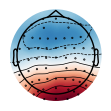

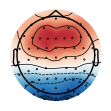

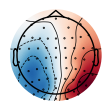

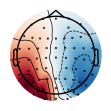

In [32]:
for i in range(4):
    mne.viz.plot_topomap(clusters2[i], raw.info, show=True)

<Axes: >

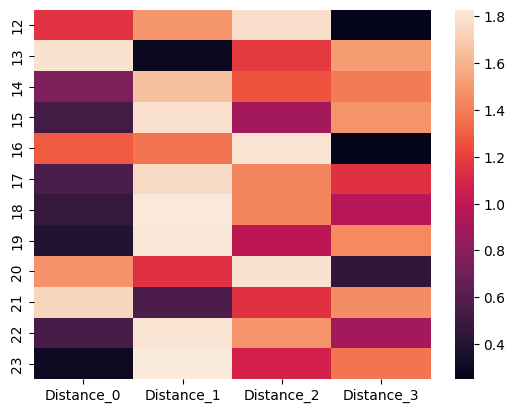

In [49]:
import seaborn as sns

sns.heatmap(clustering2.drop(columns=["Cluster"])[4*3:].head(12))

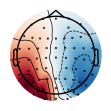

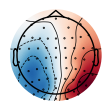

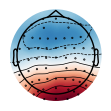

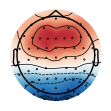

In [78]:
global_maps = pd.DataFrame(clusters2.T, columns=["C", "D", "B", "A"])
global_maps = global_maps.reindex(["A", "B", "C", "D"], axis=1)
# global_maps
for i in range(4):
    mne.viz.plot_topomap(global_maps.T.to_numpy()[i], raw.info, show=True)

In [280]:
global_maps.to_csv(folders.save_data + "global_maps.csv", index=False)

In [124]:
clustering_user, clusters_user, cluster_info_user = cluster(ms_df[:12].values, n_clusters=4, method='kmean', verbose=True)

Initialization complete
Iteration 0, inertia 2.3567471833882316.
Iteration 1, inertia 0.9540075980355647.
Converged at iteration 1: strict convergence.


In [125]:
clustering_user

,Distance_0,Distance_1,Distance_2,Distance_3,Cluster
0,0.916091,1.475086,0.251408,1.476402,2
1,1.651791,0.414059,1.118258,1.863247,1
2,0.694083,1.712405,1.622539,0.274042,3
3,0.316319,1.871162,1.154472,0.677195,0
4,1.106581,1.402041,0.040116,1.611208,2
5,1.864196,0.349269,1.614731,1.806757,1
6,0.397279,1.640190,1.316430,0.651264,0
7,0.836123,1.865585,1.652606,0.284921,3
8,1.297426,1.326413,0.260228,1.729276,2
9,1.743584,0.186498,1.496259,1.774469,1


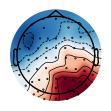

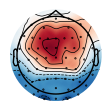

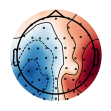

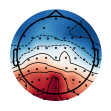

In [126]:
for i in range(4):
    mne.viz.plot_topomap(clusters_user[i], raw.info, show=True)

In [146]:
# print(np.argmin(scipy.spatial.distance.cdist(clusters_user, global_maps.T), axis=1))
arr = scipy.spatial.distance.cdist(clusters_user, global_maps.T)
arr

array([[1.46818092, 0.94127511, 0.47770597, 1.70500695],
       [1.36711743, 1.29198113, 1.70327537, 0.31876249],
       [1.76943971, 0.25642848, 1.27500083, 1.27221783],
       [1.06022558, 1.41292317, 0.41157132, 1.77364598]])

In [232]:
arr = scipy.spatial.distance.cdist(clusters_user, global_maps.T)
arr_buf = arr.copy()
# arr.min()
remap_df = pd.DataFrame(columns=["Distance_A", "Distance_B", "Distance_C", "Distance_D", "label"])

labels = {
    0: "A",
    1: "B",
    2: "C",
    3: "D"
}

for i in range(4):
    index = np.argwhere(arr_buf == np.min(arr_buf))
    data_index = index[0][0]
    label_index = index[0][1]
    remap_df = pd.concat([remap_df, pd.DataFrame(
        [[arr[data_index, 0], arr[data_index, 1], arr[data_index, 2], arr[data_index, 3], labels[label_index]]],
        columns=["Distance_A", "Distance_B", "Distance_C", "Distance_D", "label"],
        index=[data_index]
    )])
    arr_buf[data_index, :] = np.inf
    arr_buf[:, label_index] = np.inf
    
remap_df.sort_index(inplace=True)

C:\Users\bortn\AppData\Local\Temp\ipykernel_15804\2667449652.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  remap_df = pd.concat([remap_df, pd.DataFrame(


In [218]:
remap_df

,Distance_A,Distance_B,Distance_C,Distance_D,label
0,1.468181,0.941275,0.477706,1.705007,A
1,1.367117,1.291981,1.703275,0.318762,D
2,1.769440,0.256428,1.275001,1.272218,B
3,1.060226,1.412923,0.411571,1.773646,C


In [268]:
arr = scipy.spatial.distance.cdist(clusters_user, global_maps.T)
arr_buf = arr.copy()
# arr.min()
remap_df = pd.DataFrame(columns=["Distance_A", "Distance_B", "Distance_C", "Distance_D", "label"])
labels = {
    0: "A",
    1: "B",
    2: "C",
    3: "D"
}

remapper = {
}

for i in range(4):
    index = np.argwhere(arr_buf.T[i] == np.min(arr_buf.T[i]))[0][0]
    if index in remapper:
        assigned_label = remapper[index]
        next_nearest_curr_ms_val = arr_buf[index].take([i, assigned_label])
        next_nearest_conflicting_ms_val = arr_buf[remapper[index]].take([i, assigned_label])
        print(next_nearest_curr_ms_val, next_nearest_conflicting_ms_val)
    remapper[index] = i



    # prev = arr_buf[index][remapper[index]]
    # curr = arr_buf[index][i]   
    #     if(curr < prev):
    #         conflicting_val = remap_df.loc[remap_df["label"] == labels[remapper[index]]]
    #         print(conflicting_val)
    #         arr_buf[index][remapper[index]] = np.inf
    #         index = np.argwhere(arr_buf.T[i] == np.min(arr_buf.T[i]))[0][0]
    #     arr_buf.T[i][index] = np.inf
    #     index = np.argwhere(arr_buf.T[i] == np.min(arr_buf.T[i]))[0][0]
    # remap_df = pd.concat([remap_df, pd.DataFrame([[arr[index, 0], arr[index, 1], arr[index, 2], arr[index, 3], labels[i]]], columns=["Distance_A", "Distance_B", "Distance_C", "Distance_D", "label"], index=[index])])

[0.41157132 1.06022558] [0.47770597 1.46818092]


# ПЕРЕСТАНОВКАМИ

In [426]:
def calc_regroup_variants(available: [int], max_len=4, current_len=0):
    # print(current_len, max_len)
    if len(available) == 1:
        return available
    variants = []
    current_len += 1
    if current_len == max_len:
        return available
    for num in available:
        available_copy = available.copy()
        available_copy.remove(num)
        if num < max_len and num+max_len in available_copy:
            available_copy.remove(num+max_len)
        elif num >= max_len and num-max_len in available_copy:
            available_copy.remove(num-max_len)
        # print(available_copy)
        for variant in calc_regroup_variants(available_copy, max_len=max_len, current_len=current_len):
            if isinstance(variant, int):
                variants.append([num, variant])
            else:
                variants.append([num, *variant])
    return variants

In [427]:
calc_regroup_variants([0, 1, 2, 3], max_len=2)

[[0, 1], [0, 3], [1, 0], [1, 2], [2, 1], [2, 3], [3, 0], [3, 2]]

In [479]:
from functools import reduce

remap_df = pd.DataFrame(columns=["Distance_A", "Distance_B", "Distance_C", "Distance_D", "label"])
remap_df_inv = pd.DataFrame(columns=["Distance_A", "Distance_B", "Distance_C", "Distance_D", "label", "inv"])
labels = {
    0: "A",
    1: "B",
    2: "C",
    3: "D"
}
# unique_regroup_variants = {}
inverted_clusters_user = clusters_user * -1
clusters_user_and_inv = np.append(clusters_user, inverted_clusters_user, axis=0)
# print(clusters_user_and_inv.shape)
distances = scipy.spatial.distance.cdist(clusters_user_and_inv, global_maps.T)
# distances
min_combination = []
min_distance = np.inf
min_nums = []
for variant in (calc_regroup_variants([0, 1, 2, 3, 4, 5, 6, 7], max_len=4)):
    # print(variant)
    dist = 0
    # print(distances)
    for i in range(4):
        # print(distances.T[i, variant[i]])
        dist += distances.T[i, variant[i]]
    # print(distances.take(variant).sum())
    # dist = distances.take(variant).sum()
    if dist < min_distance:
        min_distance = dist
        min_combination = variant
        min_nums = [distances.T[i, variant[i]] for i in range(4)]
print("##########")
print(min_combination)
print(min_nums)
print(min_distance)
print(distances)


for enum_idx, i in enumerate(min_combination):
    print(enum_idx, i)
    # label = (labels[i] if i < 4 else labels[i-4]) if i in min_combination else ""
    real_idx = i if i < 4 else i-4
    remap_df_inv = pd.concat([remap_df_inv, pd.DataFrame([[distances.T[0, i], distances.T[1, i], distances.T[2, i], distances.T[3, i], labels[enum_idx], i>=4]], columns=["Distance_A", "Distance_B", "Distance_C", "Distance_D", "label", "inv"], index=[real_idx])])
    # remap_df_inv = pd.concat([remap_df_inv, pd.DataFrame([[distances[i+4, 0], distances[i+4, 1], distances[i+4, 2], distances[i+4, 3], labels[min_combination[i]], True]], columns=["Distance_A", "Distance_B", "Distance_C", "Distance_D", "label", "inv"], index=[i+4])])


    # unique_regroup_variants[tuple(variant)] += distances.take(variant)

# unique_regroup_variants
                                
# 
# print(unique_regroup_variants)
# for variant in unique_regroup_variants:
#     for i in range(4):
#         unique_regroup_variants[variant] += distances[i, variant[i]]

# print(unique_regroup_variants)
# 
# minimal = min(unique_regroup_variants, key=unique_regroup_variants.get)
# 
# for i in range(4):
#     remap_df = pd.concat([remap_df, pd.DataFrame([[distances[i, 0], distances[i, 1], distances[i, 2], distances[i, 3], labels[minimal[i]]]], columns=["Distance_A", "Distance_B", "Distance_C", "Distance_D", "label"], index=[i])])


#[0.94127511 0.47770597 1.36711743 0.31876249]

##########
[4, 2, 3, 1]
[1.0066263332178806, 0.256428477255604, 0.411571321924984, 0.31876248763786164]
1.9933886200363302
[[1.46818092 0.94127511 0.47770597 1.70500695]
 [1.36711743 1.29198113 1.70327537 0.31876249]
 [1.76943971 0.25642848 1.27500083 1.27221783]
 [1.06022558 1.41292317 0.41157132 1.77364598]
 [1.00662633 1.4968453  1.69702649 0.58213504]
 [1.13857089 1.20574932 0.45106195 1.77223654]
 [0.40606764 1.78542576 1.26863344 1.32451792]
 [1.46511366 1.10994474 1.74370166 0.44932658]]
0 4
1 2
2 3
3 1


C:\Users\bortn\AppData\Local\Temp\ipykernel_15804\803413071.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  remap_df_inv = pd.concat([remap_df_inv, pd.DataFrame([[distances.T[0, i], distances.T[1, i], distances.T[2, i], distances.T[3, i], labels[enum_idx], i>=4]], columns=["Distance_A", "Distance_B", "Distance_C", "Distance_D", "label", "inv"], index=[real_idx])])


In [480]:
remap_df_inv.sort_index()

,Distance_A,Distance_B,Distance_C,Distance_D,label,inv
0,1.006626,1.496845,1.697026,0.582135,A,True
1,1.367117,1.291981,1.703275,0.318762,D,False
2,1.769440,0.256428,1.275001,1.272218,B,False
3,1.060226,1.412923,0.411571,1.773646,C,False


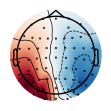

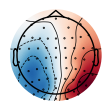

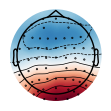

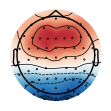

In [456]:
for i in range(4):
    mne.viz.plot_topomap(global_maps[labels[i]].T, raw.info, show=True)

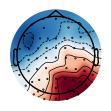

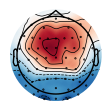

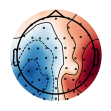

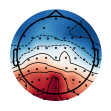

In [441]:
for i in range(4):
    mne.viz.plot_topomap(clusters_user[i], raw.info, show=True)

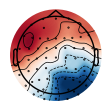

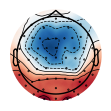

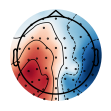

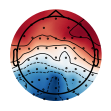

In [442]:
for i in range(4):
    mne.viz.plot_topomap(clusters_user[i]*-1, raw.info, show=True)

In [282]:
remap_df.sort_index(inplace=True)
remap_df

,Distance_A,Distance_B,Distance_C,Distance_D,label
0,1.468181,0.941275,0.477706,1.705007,C
1,1.367117,1.291981,1.703275,0.318762,D
2,1.769440,0.256428,1.275001,1.272218,B
3,1.060226,1.412923,0.411571,1.773646,A


<Axes: >

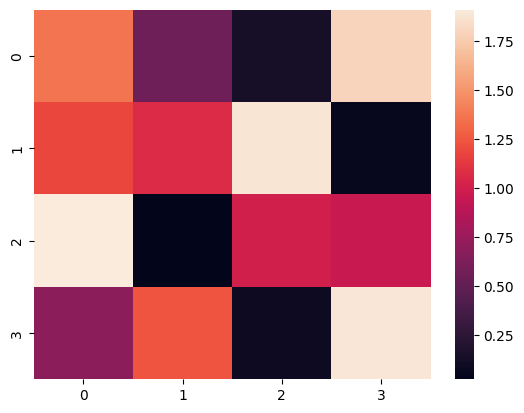

In [283]:
sns.heatmap(scipy.spatial.distance.cdist(clusters_user, global_maps.T, 'correlation'))

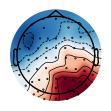

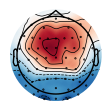

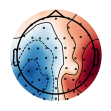

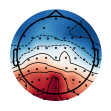

In [284]:
for i in range(4):
    mne.viz.plot_topomap(clusters_user[i], raw.info, show=True)

<Axes: >

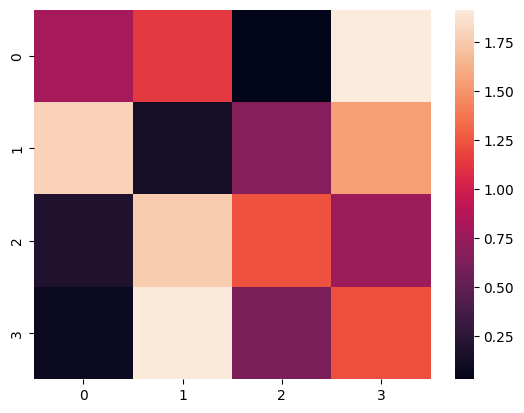

In [60]:
sns.heatmap(scipy.spatial.distance.cdist(ms_df[:4], clusters2, 'correlation'))

In [34]:
# kmeans = sklearn.cluster.KMeans(n_clusters=4, max_iter=100000, tol=1e-9).fit(ms_df.values)

In [35]:
# np.bincount(kmeans.labels_)

In [36]:
# for i in range(4):
#     mne.viz.plot_topomap(kmeans.cluster_centers_[i], mhw.raw.info, show=True)

In [37]:
# kmeans2 = sklearn.cluster.BisectingKMeans(n_clusters=4, init='k-means++').fit(ms_df.values)

In [38]:
# pd.DataFrame.from_records([kmeans2.labels_]).T
# np.bincount(kmeans2.labels_)

In [39]:
# for i in range(4):
#     mne.viz.plot_topomap(kmeans2.cluster_centers_[i], mhw.raw.info, show=True)

In [40]:
# centroid, label = scipy.cluster.vq.kmeans2(ms_df.values, 4, minit='++', iter=1000)